# Aprendizaje supervisado aplicado a series de tiempo
## Celeste Zuluaga, Alejandra Jaimes y Jose Ríos



In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
! git clone https://github.com/ijrios/database_finalis_opus.git
! git clone https://github.com/ijrios/databases_train_finalis_opus.git
! git clone https://github.com/ijrios/database_test_finalis_opus.git

fatal: destination path 'database_finalis_opus' already exists and is not an empty directory.
fatal: destination path 'databases_train_finalis_opus' already exists and is not an empty directory.
fatal: destination path 'database_test_finalis_opus' already exists and is not an empty directory.


In [3]:
pip install rarfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import rarfile

def descomprimir_rar(ruta_archivo_rar, ruta_destino):
    with rarfile.RarFile(ruta_archivo_rar) as rf:
        rf.extractall(ruta_destino)

In [5]:
# Descomprimiendo archivos
ruta_archivo_rar = '/content/database_finalis_opus/holidays_events.rar'
ruta_destino = '/content/database_finalis_opus'

ruta_archivo_rar_duo = '/content/database_test_finalis_opus/test.rar'
ruta_destino_duo = '/content/database_test_finalis_opus'

ruta_archivo_rar_tris = '/content/databases_train_finalis_opus/train_database.rar'
ruta_destino_tris = '/content/databases_train_finalis_opus'

descomprimir_rar(ruta_archivo_rar, ruta_destino)
descomprimir_rar(ruta_archivo_rar_duo, ruta_destino_duo)
descomprimir_rar(ruta_archivo_rar_tris, ruta_destino_tris)

In [6]:
from pandas import read_csv
# load the dataset
dataframe = read_csv('/content/database_finalis_opus/holidays_events.csv')
data_test = read_csv('/content/database_test_finalis_opus/test.csv')
data_train = read_csv('/content/databases_train_finalis_opus/train.csv')

In [7]:
data_test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [8]:
#train data
beverages_train = data_train.loc[data_train['family'] == 'BEVERAGES']
beauty_data_train = data_train.loc[data_train['family'] == 'BEAUTY']
books_data_train = data_train.loc[data_train['family'] == 'BOOKS']
schooland_data_train = data_train.loc[data_train['family'] == 'SCHOOL AND OFFICE SUPPLIES']
produce = data_train.loc[data_train['family'] == 'PRODUCE']

In [9]:
#test data
automotive_data_test = data_test.loc[data_test['family'] == 'AUTOMOTIVE']
beauty_data_test = data_test.loc[data_test['family'] == 'BEAUTY']
books_data_test = data_test.loc[data_test['family'] == 'BOOKS']
schooland_data_test = data_test.loc[data_test['family'] == 'SCHOOL AND OFFICE SUPPLIES']

# Análisis con todas las tiendas y un solo producto (beverages) - Jose Ríos

Organizamos datos de train y test

In [10]:
data_unus_train = pd.DataFrame()
data_unus_train['date'] = pd.to_datetime(beverages_train['date'])
data_unus_train['sales'] = beverages_train['sales']
data_unus_train['store_nbr'] = beverages_train['store_nbr']
data_unus_train.set_index('date', inplace=True)

In [11]:
#data_unus_train = data_unus_train.resample('W').sum()
# Agrupar por 'Tienda' y 'Fecha' y sumar las ventas
data_unus_train = beverages_train.groupby(['date']).sum()
data_unus_train.head()

<ipython-input-11-1a4921974594>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_unus_train = beverages_train.groupby(['date']).sum()


,id,store_nbr,sales,onpromotion
date,,,,
2013-01-01,47385,1485,810.0,0
2013-01-02,143613,1485,72092.0,0
2013-01-03,239841,1485,52105.0,0
2013-01-04,336069,1485,54167.0,0
2013-01-05,432297,1485,77818.0,0


Observemos que en una serie de tiempo tenemos los indices en formato de fecha y la variable de las ventas. Si queremos implementar un algoritmo de regresión basado en aprendizaje supervisado, necesitamos tener además de los datos de entrada un vector de etiquetas o datos de salida (y). Vamos a ver varias alternativas:

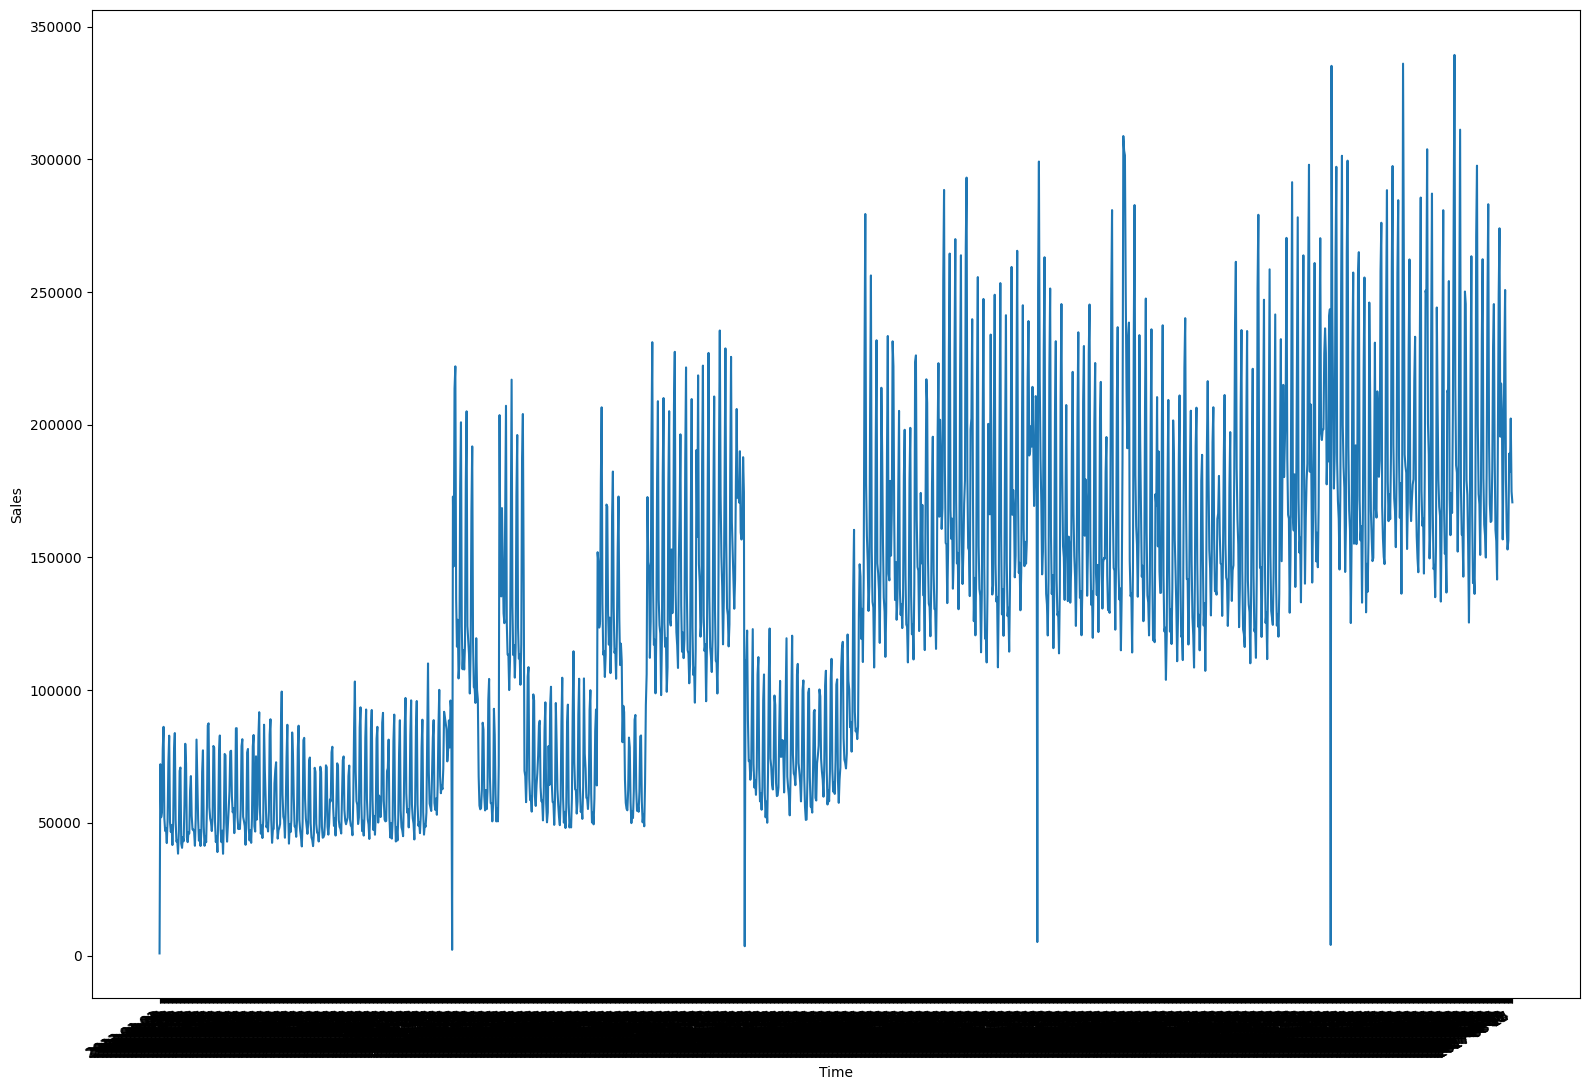

In [12]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(data_unus_train['sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
fig.autofmt_xdate()
plt.tight_layout()

## Predecir cada dato siguiente a partir de una observación previa.

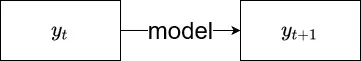

Este es un modelo muy básico porque es dificil que se pueda predecir un dato solo a partir de una observación previa. Mas adelante veremos esta implementación pero con una ventana de observación mayor. Lo importante es que debemos generar una matriz con los datos de entrada y de salida para poder trabajar el esquema tal cual como se ha revisado anteriormente para problemas de clasificación supervisada.

Vamos a adicionar una columna equivalente a la salida que se va a predecir. Para esto se utiliza el método *shift*.

In [13]:
data_unus_train = data_unus_train.copy()
data_unus_train = data_unus_train.fillna(method='bfill')
data_unus_train['y'] = data_unus_train['sales'].shift(-1)

In [14]:
data_unus_train.head()

,id,store_nbr,sales,onpromotion,y
date,,,,,
2013-01-01,47385,1485,810.0,0,72092.0
2013-01-02,143613,1485,72092.0,0,52105.0
2013-01-03,239841,1485,52105.0,0,54167.0
2013-01-04,336069,1485,54167.0,0,77818.0
2013-01-05,432297,1485,77818.0,0,86184.0


Con esto podemos implementar un modelo que predice cada observación con la observación previa. En esta construcción se tiene un problema en la última observación que debe ser tratado mas adelante.

In [15]:
data_unus_train.tail()
#test = data_unus_train.drop(data_unus_train.tail(1).index) # Drop last row

,id,store_nbr,sales,onpromotion,y
date,,,,,
2017-08-11,161614197,1485,189111.0,961,182318.0
2017-08-12,161710425,1485,182318.0,956,202354.0
2017-08-13,161806653,1485,202354.0,986,174832.0
2017-08-14,161902881,1485,174832.0,957,170773.0
2017-08-15,161999109,1485,170773.0,982,NaN


No tenemos que dividir el conjunto de datos de test y train porque ya la serie viene tiene los datos por separado

In [16]:
train = data_unus_train[:-104]
test = data_unus_train[-104:]
test = test.fillna(method='bfill')

In [17]:
X = data_unus_train
y = data_unus_train['sales'].shift(-1)
X = X.fillna(0)
y = y.fillna(0)

In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Assuming you have a pandas DataFrame 'df' with a time series column 'date' and a target column 'target'

# Define the number of folds for cross-validation
n_splits = 5

# Initialize the time series cross-validator
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the hyperparameters to search over
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
}

# Initialize the DecisionTreeRegressor model
model = DecisionTreeRegressor()

# Initialize the grid search with cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',  # Use mean squared error as the evaluation metric
    verbose=1
)

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Optionally, evaluate the best model on a separate test set
X_test = train # Test set features
y_test = test  # Test set target
y_pred = best_model.predict(X_test)
y_test = y_test.fillna(0)
y_pred = np.repeat(y_pred, y_test.shape[0])
y_pred = y_pred[:104]
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

Vamos a implementar dos modelos de regresión, arboles de decisión y un algoritmos de regresión basado en Gradient Boosting. La predicción la agregamos como una columna adicional en el dataframe.

In [18]:
from sklearn.tree import DecisionTreeRegressor
X_train = train['sales'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['sales'].values.reshape(-1,1)
y_test = test['y'].values.reshape(-1,1)
# Initialize the model
dt_reg = DecisionTreeRegressor(random_state=42)
# Fit the model
dt_reg.fit(X=X_train, y=y_train)
# Make predictions
dt_pred = dt_reg.predict(X_test)
# Assign predictions to a new column in test
test['dt_pred'] = dt_pred

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y=y_train.ravel())
gbr_pred = gbr.predict(X_test)
test['gbr_pred'] = gbr_pred

In [20]:
test.head()

,id,store_nbr,sales,onpromotion,y,dt_pred,gbr_pred
date,,,,,,,
2017-05-04,152087625,1485,149629.0,972,161279.0,128954.0,164228.126488
2017-05-05,152183853,1485,161279.0,972,233814.0,132978.0,157842.200267
2017-05-06,152280081,1485,233814.0,979,287104.0,193033.0,182851.163450
2017-05-07,152376309,1485,287104.0,995,166843.0,178705.0,183720.464918
2017-05-08,152472537,1485,166843.0,914,145619.0,150444.0,173695.829251


Con el fin de tener una comparación, vamos a agregar una columna de base o referencia donde la predicción es igual a la entrada:

In [21]:
test_2 = test.copy()
test_2['baseline_pred'] = test_2['sales']
test_2['gbr_pred'] = gbr_pred
test_3 = test_2.copy()
test_3_fill = test_3.fillna(0)
test_3_fill.head()

,id,store_nbr,sales,onpromotion,y,dt_pred,gbr_pred,baseline_pred
date,,,,,,,,
2017-05-04,152087625,1485,149629.0,972,161279.0,128954.0,164228.126488,149629.0
2017-05-05,152183853,1485,161279.0,972,233814.0,132978.0,157842.200267,161279.0
2017-05-06,152280081,1485,233814.0,979,287104.0,193033.0,182851.163450,233814.0
2017-05-07,152376309,1485,287104.0,995,166843.0,178705.0,183720.464918,287104.0
2017-05-08,152472537,1485,166843.0,914,145619.0,150444.0,173695.829251,166843.0


A continuación vamos a implementar dos medidas de desempeño:



In [22]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

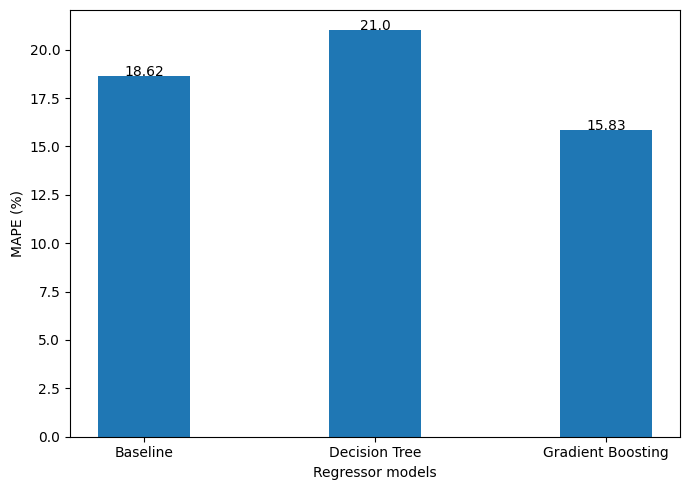

In [23]:
baseline_mape = mape(test_2['y'], test_2['baseline_pred'])
dt_mape = mape(test_2['y'], test_2['dt_pred'])
gbr_mape = mape(test_2['y'], test_2['gbr_pred'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_mape, gbr_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
#ax.set_ylim(0, 0.3)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

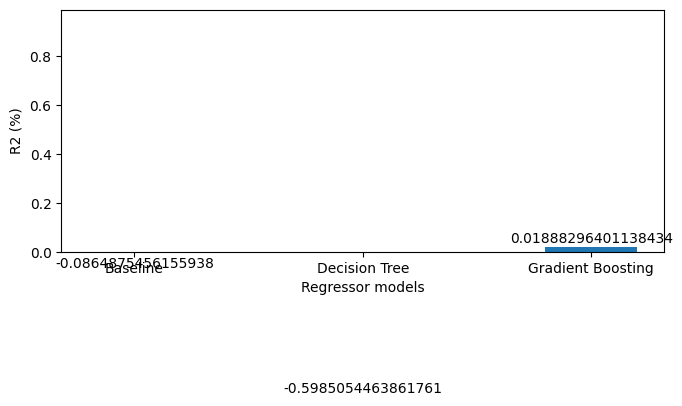

In [24]:
from sklearn.metrics import r2_score
baseline_r2 = r2_score(test_3_fill['y'], test_3_fill['baseline_pred'])
dt_r2 = r2_score(test_3_fill['y'], test_3_fill['dt_pred'])
gbr_r2 = r2_score(test_3_fill['y'], test_3_fill['gbr_pred'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_r2, dt_r2, gbr_r2]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('R2 (%)')
ax.set_ylim(0, 0.99)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

Podemos observar que los modelos no superar la referencia.

##Predicción utilizando una secuencia de valores pasados:

Lo que vamos a realizar a continuación es aumentar la ventana de observación para la entrada del modelo. Es decir, vamos a aumentar el número de características que ingresa al modelo. 

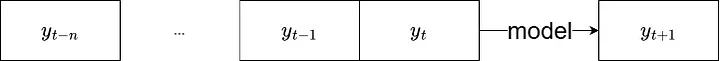

Revisemos la siguiente función que genera una matriz donde cada entrada tiene por ejemplo 5 muestras previas de la serie de tiempo para predecir el dato siguiente:

In [25]:
def window_input(window_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = test_3_fill.copy()
    
    i = 1
    while i < window_length:
        df[f'x_{i}'] = df['sales'].shift(-i)
        i = i + 1
    
    i = window_length
    while i < window_length*2:
        df[f'x_{i}'] = df['sales'].shift(-i)-df['sales']
        i = i + 1
        
    if i == window_length*2:
        df['y'] = df['sales'].shift(-i)
        
    # Drop rows where there is a NaN
    df = df.dropna(axis=0)
        
    return df

In [26]:
new_df = window_input(10, test_3_fill)

In [27]:
new_df.head(10)

,id,store_nbr,sales,onpromotion,y,dt_pred,gbr_pred,baseline_pred,x_1,x_2,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
date,,,,,,,,,,,,,,,,,,,,,
2017-05-04,152087625,1485,149629.0,972,153706.0,128954.0,164228.126488,149629.0,161279.0,233814.0,...,57357.0,29485.0,19469.0,16046.0,-16248.0,12089.0,78271.0,131220.0,19514.0,1808.0
2017-05-05,152183853,1485,161279.0,972,136779.0,132978.0,157842.200267,161279.0,233814.0,287104.0,...,17835.0,7819.0,4396.0,-27898.0,439.0,66621.0,119570.0,7864.0,-9842.0,-7573.0
2017-05-06,152280081,1485,233814.0,979,212870.0,193033.0,182851.163450,233814.0,287104.0,166843.0,...,-64716.0,-68139.0,-100433.0,-72096.0,-5914.0,47035.0,-64671.0,-82377.0,-80108.0,-97035.0
2017-05-07,152376309,1485,287104.0,995,212127.0,178705.0,183720.464918,287104.0,166843.0,145619.0,...,-121429.0,-153723.0,-125386.0,-59204.0,-6255.0,-117961.0,-135667.0,-133398.0,-150325.0,-74234.0
2017-05-08,152472537,1485,166843.0,914,254132.0,150444.0,173695.829251,166843.0,145619.0,147196.0,...,-33462.0,-5125.0,61057.0,114006.0,2300.0,-15406.0,-13137.0,-30064.0,46027.0,45284.0
2017-05-09,152568765,1485,145619.0,862,171962.0,122071.0,155025.160394,145619.0,147196.0,135028.0,...,16099.0,82281.0,135230.0,23524.0,5818.0,8087.0,-8840.0,67251.0,66508.0,108513.0
2017-05-10,152664993,1485,147196.0,1833,158403.0,121907.0,150694.264532,147196.0,135028.0,154026.0,...,80704.0,133653.0,21947.0,4241.0,6510.0,-10417.0,65674.0,64931.0,106936.0,24766.0
2017-05-11,152761221,1485,135028.0,1480,174304.0,108605.0,151652.930393,135028.0,154026.0,244193.0,...,145821.0,34115.0,16409.0,18678.0,1751.0,77842.0,77099.0,119104.0,36934.0,23375.0
2017-05-12,152857449,1485,154026.0,1522,166771.0,182043.0,157386.299112,154026.0,244193.0,206986.0,...,15117.0,-2589.0,-320.0,-17247.0,58844.0,58101.0,100106.0,17936.0,4377.0,20278.0


A continuación extraemos la variables de entrada y la salida para entrenar el modelo y separamos entre un conjunto de test y de entrenamiento:

In [28]:
from sklearn.model_selection import train_test_split

X = new_df.drop('y',axis=1).values
y = new_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

En este caso como predictor de referencia vamos a utilizar un modelo donde el dato futuro se predice como la media de los datos observados.

In [29]:
baseline_pred = []

for row in X_test:
    baseline_pred.append(np.mean(row))

In [30]:
gbr_5 = GradientBoostingRegressor(random_state=42)

gbr_5.fit(X_train, y_train.ravel())

gbr_5_pred = gbr_5.predict(X_test)

In [36]:
dt_reg_5 = DecisionTreeRegressor(random_state=42)

dt_reg_5.fit(X_train, y_train)

dt_reg_5_pred = dt_reg_5.predict(X_test)

Revisemos la métricas de desempeño:

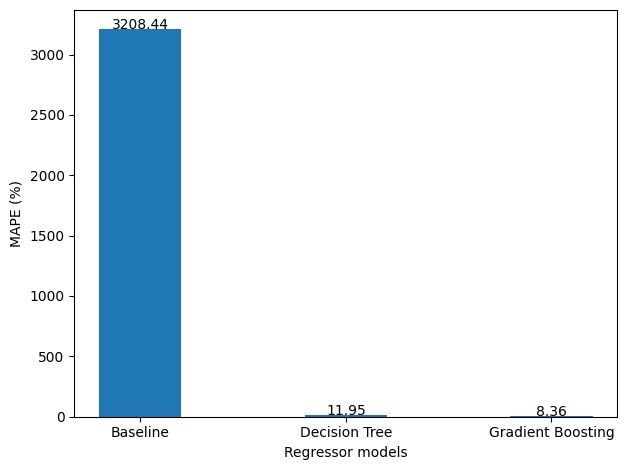

In [37]:
baseline_mape = mape(y_test, baseline_pred)
dt_5_mape = mape(y_test, dt_reg_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_5_mape, gbr_5_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
#ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

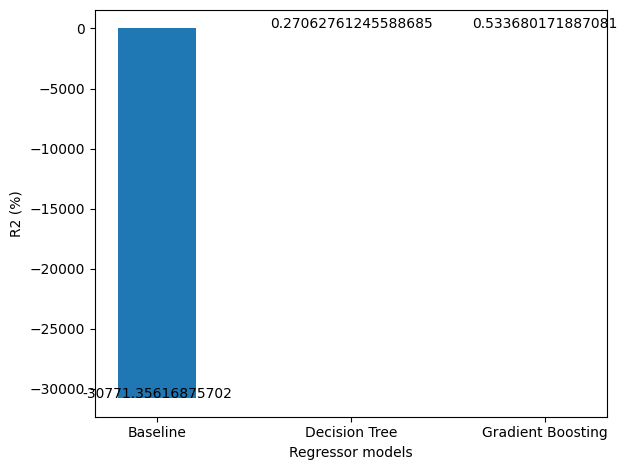

In [38]:
baseline_r2 = r2_score(y_test, baseline_pred)
dt_5_r2 = r2_score(y_test, dt_reg_5_pred)
gbr_5_r2 = r2_score(y_test, gbr_5_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_r2, dt_5_r2, gbr_5_r2]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('R2 (%)')
#ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

Observemos que todavia es desempeño no supera el predictor de referencia. Lo que vamos a realizar a continuación es aumentar la ventana e igualmente aumentar la ventana de predicción. En este tipo de aplicaciones la ventana de observación puede ser considerado un hiperparámetro y debe ser ajustado.

# Análisis de la segunda tienda y un solo producto - Alejandra Jaimes

In [40]:
data_duo_train = beauty_data_train[beauty_data_train['store_nbr'] == 10]
data_duo_train.head()

,id,date,store_nbr,family,sales,onpromotion
35,35,2013-01-01,10,BEAUTY,0.0,0
1817,1817,2013-01-02,10,BEAUTY,6.0,0
3599,3599,2013-01-03,10,BEAUTY,3.0,0
5381,5381,2013-01-04,10,BEAUTY,4.0,0
7163,7163,2013-01-05,10,BEAUTY,3.0,0


In [42]:
data_duo_train.set_index('date', inplace=True)
data_duo_train.drop(['id','family','onpromotion','store_nbr'],axis=1,inplace=True)
data_duo_train.head()

<ipython-input-42-0f0389db56ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_duo_train.drop(['id','family','onpromotion','store_nbr'],axis=1,inplace=True)


,sales
date,
2013-01-01,0.0
2013-01-02,6.0
2013-01-03,3.0
2013-01-04,4.0
2013-01-05,3.0


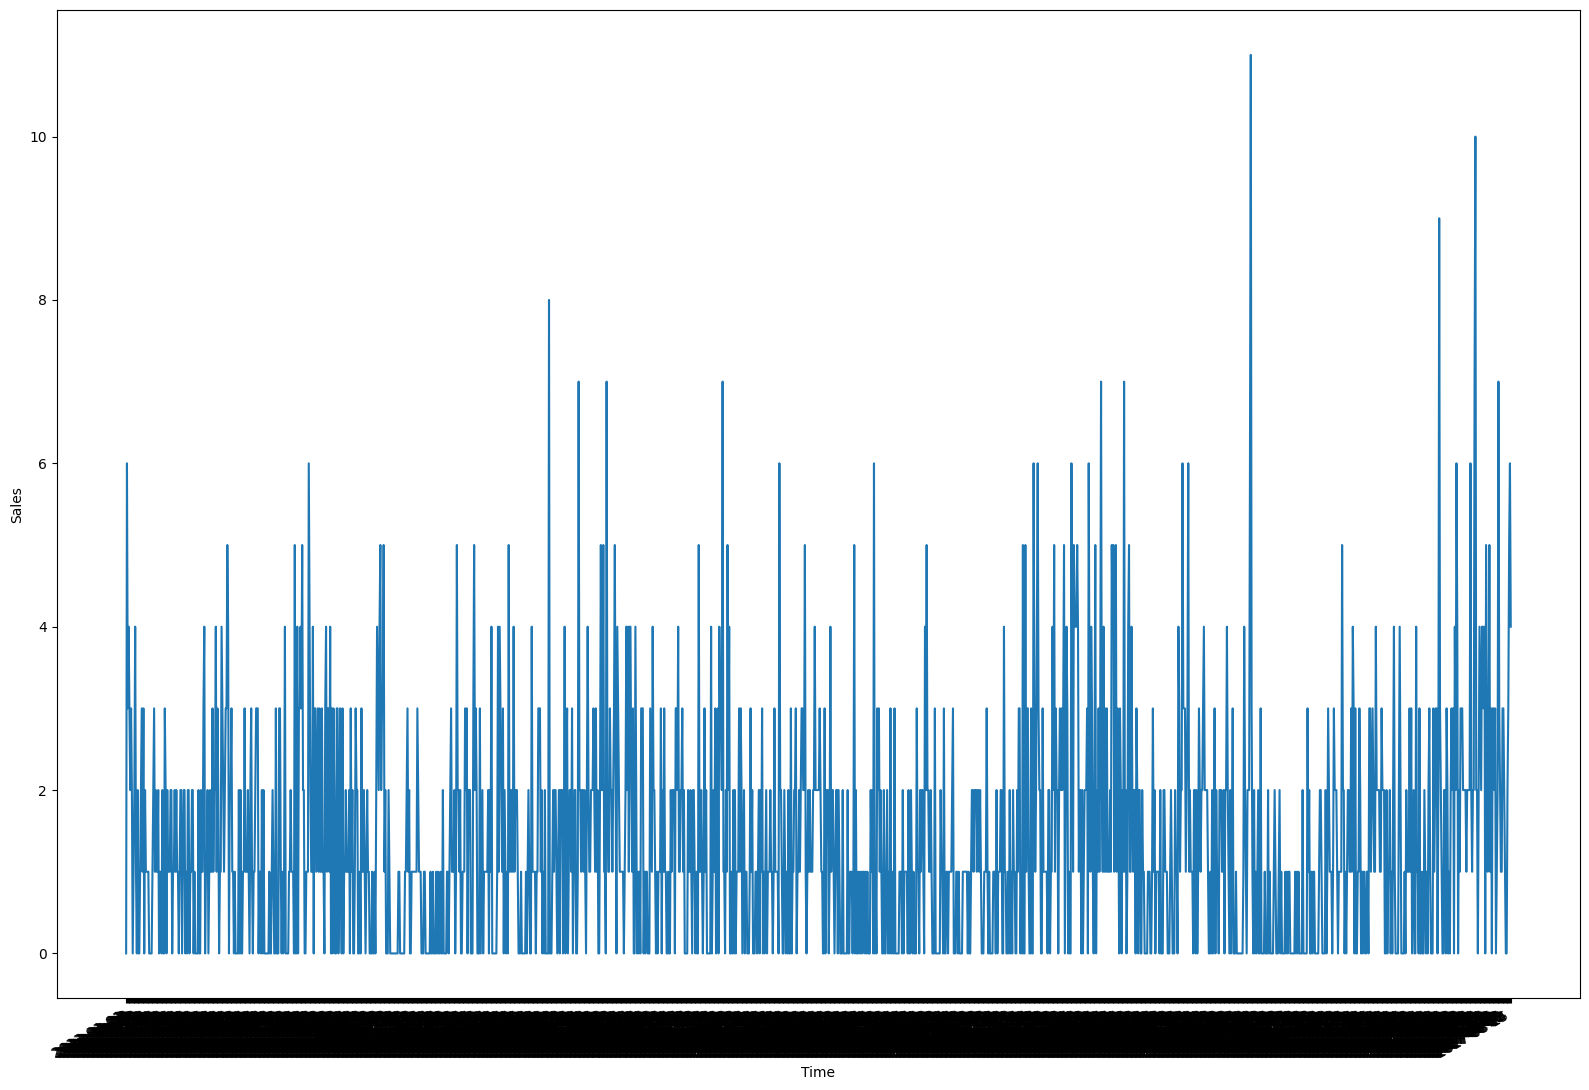

In [43]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(data_duo_train['sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
fig.autofmt_xdate()
plt.tight_layout()

Observemos que en una serie de tiempo tenemos los indices en formato de fecha y la variable de las ventas. Si queremos implementar un algoritmo de regresión basado en aprendizaje supervisado, necesitamos tener además de los datos de entrada un vector de etiquetas o datos de salida (y). Vamos a ver varias alternativas:

## Predecir cada dato siguiente a partir de una observación previa.

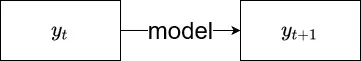

Este es un modelo muy básico porque es dificil que se pueda predecir un dato solo a partir de una observación previa. Mas adelante veremos esta implementación pero con una ventana de observación mayor. Lo importante es que debemos generar una matriz con los datos de entrada y de salida para poder trabajar el esquema tal cual como se ha revisado anteriormente para problemas de clasificación supervisada.

Vamos a adicionar una columna equivalente a la salida que se va a predecir. Para esto se utiliza el método *shift*.

In [44]:
data_duo_train = data_duo_train.copy()
data_duo_train = data_duo_train.fillna(0)
data_duo_train['y'] = data_duo_train['sales'].shift(-1)
data_duo_train.head()

,sales,y
date,,
2013-01-01,0.0,6.0
2013-01-02,6.0,3.0
2013-01-03,3.0,4.0
2013-01-04,4.0,3.0
2013-01-05,3.0,2.0


In [45]:
train = data_duo_train[:-104]
test = data_duo_train[-104:]

In [34]:
test

,id,store_nbr,sales,onpromotion,y,dt_pred,gbr_pred
date,,,,,,,
2017-05-04,152087625,1485,149629.0,972,161279.0,128954.0,164228.126488
2017-05-05,152183853,1485,161279.0,972,233814.0,132978.0,157842.200267
2017-05-06,152280081,1485,233814.0,979,287104.0,193033.0,182851.163450
2017-05-07,152376309,1485,287104.0,995,166843.0,178705.0,183720.464918
2017-05-08,152472537,1485,166843.0,914,145619.0,150444.0,173695.829251
...,...,...,...,...,...,...,...
2017-08-11,161614197,1485,189111.0,961,182318.0,259101.0,196013.304226
2017-08-12,161710425,1485,182318.0,956,202354.0,207703.0,198675.540375
2017-08-13,161806653,1485,202354.0,986,174832.0,239775.0,204496.770095


In [46]:
test = data_duo_train.fillna(0)

In [ ]:
X = data_duo_train['sales']
y = data_duo_train['sales'].shift(-1)
X.fillna(0)
y.fillna(0)
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Assuming you have a pandas DataFrame 'df' with a time series column 'date' and a target column 'target'

# Define the number of folds for cross-validation
n_splits = 5

# Initialize the time series cross-validator
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the hyperparameters to search over
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
}

# Initialize the DecisionTreeRegressor model
model = DecisionTreeRegressor()

# Initialize the grid search with cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',  # Use mean squared error as the evaluation metric
    verbose=1
)

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Optionally, evaluate the best model on a separate test set
X_test = train # Test set features
y_test = test  # Test set target
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

Con esto podemos implementar un modelo que predice cada observación con la observación previa. En esta construcción se tiene un problema en la última observación que debe ser tratado mas adelante.

Vamos a implementar dos modelos de regresión, arboles de decisión y un algoritmos de regresión basado en Gradient Boosting. La predicción la agregamos como una columna adicional en el dataframe.

In [48]:
from sklearn.tree import DecisionTreeRegressor
X_train = train['sales'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['sales'].values.reshape(-1,1)
y_test = test['y'].values.reshape(-1,1)
# Initialize the model
dt_reg = DecisionTreeRegressor(random_state=42)
# Fit the model
dt_reg.fit(X=X_train, y=y_train)
# Make predictions
dt_pred = dt_reg.predict(X_test)
# Assign predictions to a new column in test
test['dt_pred'] = dt_pred

In [49]:
test

,sales,y,dt_pred
date,,,
2013-01-01,0.0,6.0,1.030769
2013-01-02,6.0,3.0,3.272727
2013-01-03,3.0,4.0,1.606667
2013-01-04,4.0,3.0,2.033898
2013-01-05,3.0,2.0,1.606667
...,...,...,...
2017-08-11,2.0,3.0,1.393189
2017-08-12,3.0,5.0,1.606667
2017-08-13,5.0,6.0,1.571429


In [50]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y=y_train.ravel())
gbr_pred = gbr.predict(X_test)
test['gbr_pred'] = gbr_pred

In [51]:
test

,sales,y,dt_pred,gbr_pred
date,,,,
2013-01-01,0.0,6.0,1.030769,1.030959
2013-01-02,6.0,3.0,3.272727,3.269922
2013-01-03,3.0,4.0,1.606667,1.606448
2013-01-04,4.0,3.0,2.033898,2.032362
2013-01-05,3.0,2.0,1.606667,1.606448
...,...,...,...,...
2017-08-11,2.0,3.0,1.393189,1.393131
2017-08-12,3.0,5.0,1.606667,1.606448
2017-08-13,5.0,6.0,1.571429,1.572621


Con el fin de tener una comparación, vamos a agregar una columna de base o referencia donde la predicción es igual a la entrada:

In [52]:
test_3 = test.copy()
test_3['baseline_pred'] = test_3['sales']

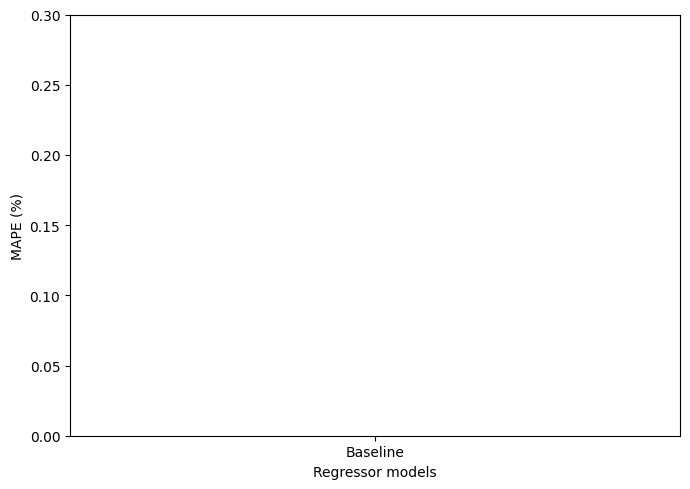

In [53]:
baseline_mape = mape(test_3['y'], test_3['baseline_pred'])
dt_mape = mape(test_3['y'], test_3['dt_pred'])
gbr_mape = mape(test['y'], test['gbr_pred'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_mape, gbr_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 0.3)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

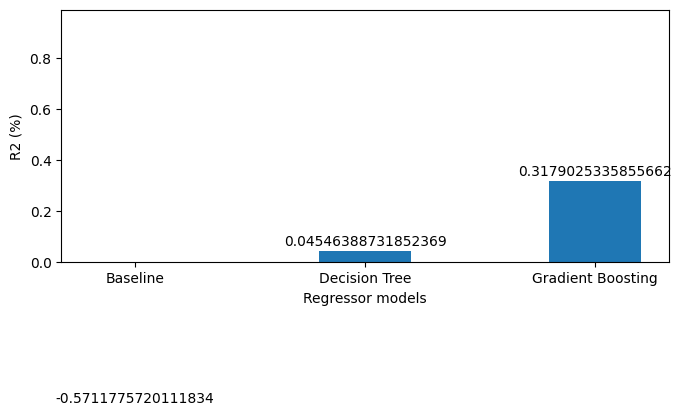

In [54]:
from sklearn.metrics import r2_score
baseline_r2 = r2_score(test_3['y'], test_3['baseline_pred'])
dt_r2 = r2_score(test_3['y'], test_3['dt_pred'])
gbr_r2 = r2_score(test_3['sales'], test_3['gbr_pred'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_r2, dt_r2, gbr_r2]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('R2 (%)')
ax.set_ylim(0, 0.99)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

##Predicción utilizando una secuencia de valores pasados:

In [55]:
new_df = window_input(10, test_3)

In [56]:
from sklearn.model_selection import train_test_split

X = new_df.drop('y',axis=1).values
y = new_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [57]:
baseline_pred = []

for row in X_test:
    baseline_pred.append(np.mean(row))

In [58]:
gbr_5 = GradientBoostingRegressor(random_state=42)

gbr_5.fit(X_train, y_train.ravel())

gbr_5_pred = gbr_5.predict(X_test)

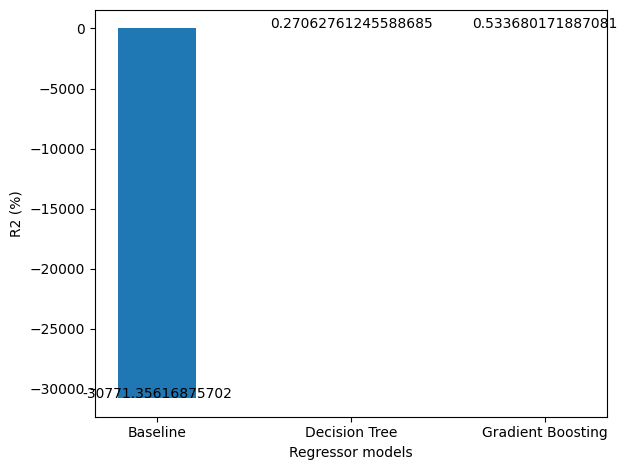

In [60]:
baseline_r2 = r2_score(y_test, baseline_pred)
dt_5_r2 = r2_score(y_test, dt_reg_5_pred)
gbr_5_r2 = r2_score(y_test, gbr_5_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_r2, dt_5_r2, gbr_5_r2]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('R2 (%)')
#ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

# Análisis de la tienda 53 y el producto "Produce" - Celeste Zuluaga

In [63]:
data_tris_train = produce[produce['store_nbr'] == 53]
data_tris_train.head()

,id,date,store_nbr,family,sales,onpromotion
1614,1614,2013-01-01,53,PRODUCE,0.0,0
3396,3396,2013-01-02,53,PRODUCE,0.0,0
5178,5178,2013-01-03,53,PRODUCE,0.0,0
6960,6960,2013-01-04,53,PRODUCE,0.0,0
8742,8742,2013-01-05,53,PRODUCE,0.0,0


Observemos que en una serie de tiempo tenemos los indices en formato de fecha y la variable de las tiendas. Si queremos implementar un algoritmo de regresión basado en aprendizaje supervisado, necesitamos tener además de los datos de entrada un vector de etiquetas o datos de salida (y). Vamos a ver varias alternativas:

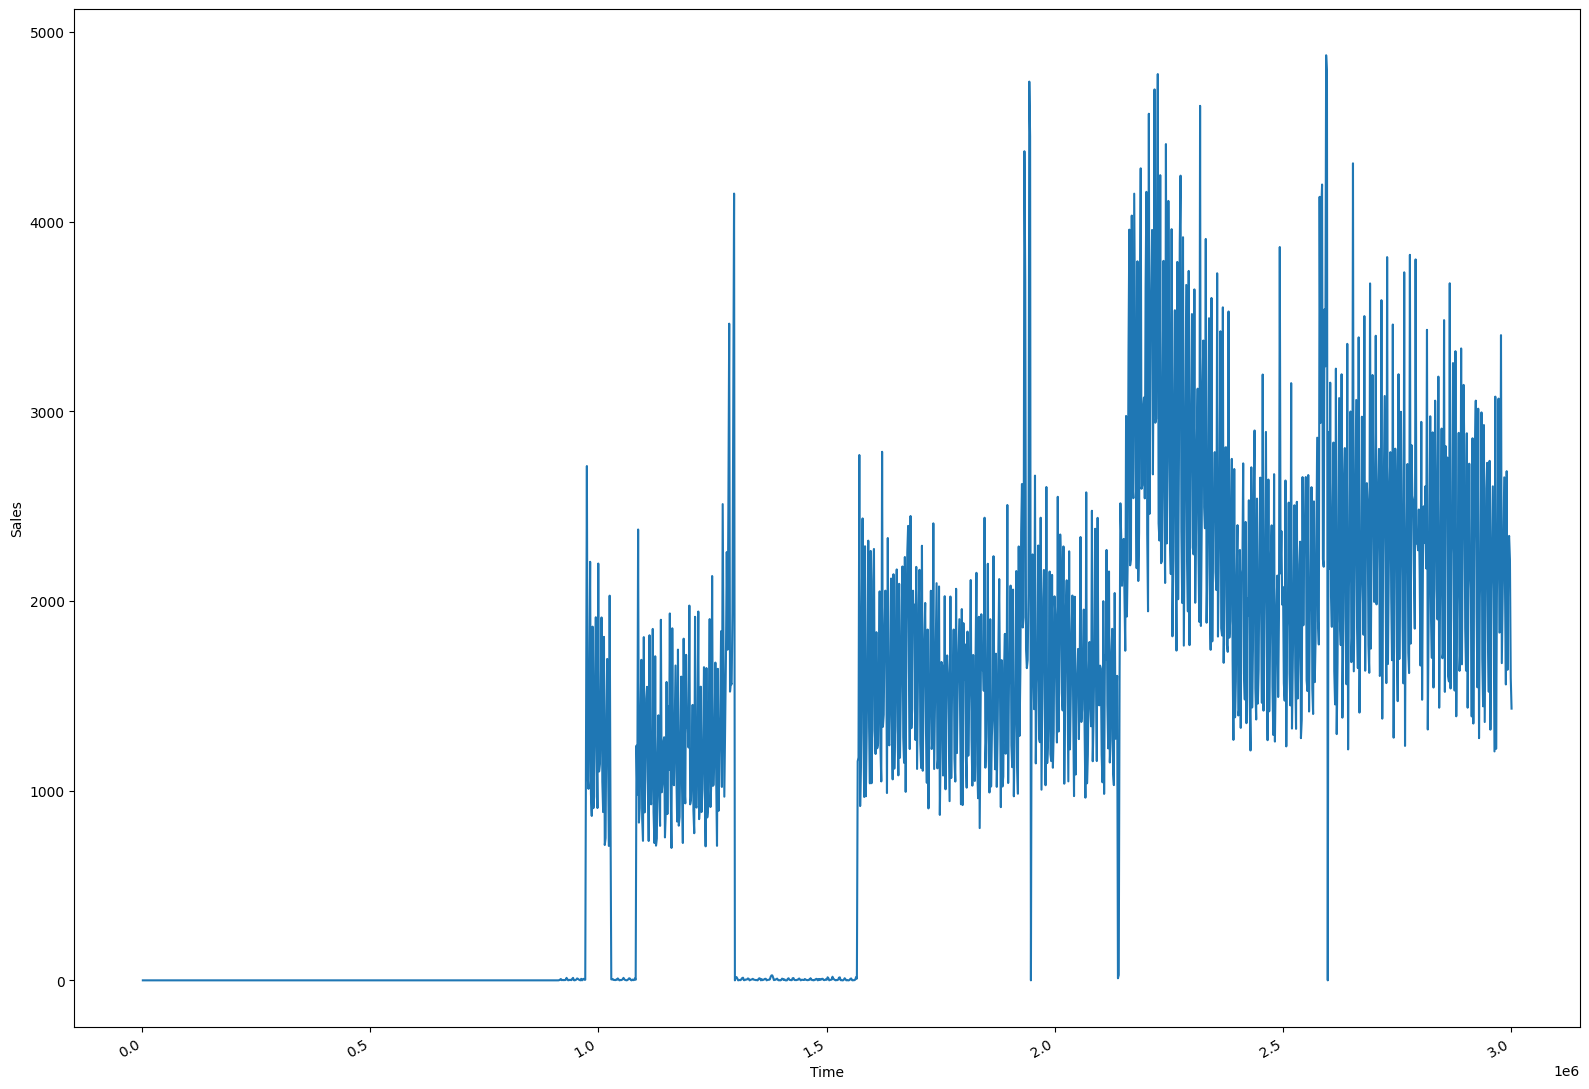

In [65]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(data_tris_train['sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
fig.autofmt_xdate()
plt.tight_layout()

## Predecir cada dato siguiente a partir de una observación previa.

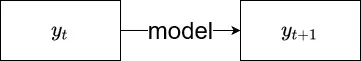

Este es un modelo muy básico porque es dificil que se pueda predecir un dato solo a partir de una observación previa. Mas adelante veremos esta implementación pero con una ventana de observación mayor. Lo importante es que debemos generar una matriz con los datos de entrada y de salida para poder trabajar el esquema tal cual como se ha revisado anteriormente para problemas de clasificación supervisada.

Vamos a adicionar una columna equivalente a la salida que se va a predecir. Para esto se utiliza el método *shift*.

In [67]:
data_tris_train = data_tris_train.copy()
data_tris_train = data_tris_train.fillna(0)
data_tris_train['y'] = data_tris_train['sales'].shift(-1)
data_tris_train.head()

,id,date,store_nbr,family,sales,onpromotion,y
1614,1614,2013-01-01,53,PRODUCE,0.0,0,0.0
3396,3396,2013-01-02,53,PRODUCE,0.0,0,0.0
5178,5178,2013-01-03,53,PRODUCE,0.0,0,0.0
6960,6960,2013-01-04,53,PRODUCE,0.0,0,0.0
8742,8742,2013-01-05,53,PRODUCE,0.0,0,0.0


Con esto podemos implementar un modelo que predice cada observación con la observación previa. En esta construcción se tiene un problema en la última observación que debe ser tratado mas adelante.

In [68]:
train = data_tris_train[:-104]
test = data_tris_train[-104:]

In [70]:
data_tris_train.tail()
data_tris_train = data_tris_train.fillna(method='bfill')
#test = data_tris_train.drop(data_unus_train.tail(1).index) # Drop last row
test.head()

,id,date,store_nbr,family,sales,onpromotion,y
2817174,2817174,2017-05-04,53,PRODUCE,1322.397,2,1906.6670
2818956,2818956,2017-05-05,53,PRODUCE,1906.667,1,2316.4890
2820738,2820738,2017-05-06,53,PRODUCE,2316.489,1,2973.5920
2822520,2822520,2017-05-07,53,PRODUCE,2973.592,1,1911.6080
2824302,2824302,2017-05-08,53,PRODUCE,1911.608,1,1699.9609


In [ ]:
X = data_tris_train['sales']
y = data_tris_train['sales'].shift(-1)
X.fillna(0)
y.fillna(0)
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Assuming you have a pandas DataFrame 'df' with a time series column 'date' and a target column 'target'

# Define the number of folds for cross-validation
n_splits = 5

# Initialize the time series cross-validator
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the hyperparameters to search over
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
}

# Initialize the DecisionTreeRegressor model
model = DecisionTreeRegressor()

# Initialize the grid search with cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',  # Use mean squared error as the evaluation metric
    verbose=1
)

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Optionally, evaluate the best model on a separate test set
X_test = train # Test set features
y_test = test  # Test set target
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

Con esto podemos implementar un modelo que predice cada observación con la observación previa. En esta construcción se tiene un problema en la última observación que debe ser tratado mas adelante.

Vamos a implementar dos modelos de regresión, arboles de decisión y un algoritmos de regresión basado en Gradient Boosting. La predicción la agregamos como una columna adicional en el dataframe.

In [71]:
from sklearn.tree import DecisionTreeRegressor
X_train = train['sales'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['sales'].values.reshape(-1,1)
y_test = test['y'].values.reshape(-1,1)
# Initialize the model
dt_reg = DecisionTreeRegressor(random_state=42)
# Fit the model
dt_reg.fit(X=X_train, y=y_train)
# Make predictions
dt_pred = dt_reg.predict(X_test)
# Assign predictions to a new column in test
test['dt_pred'] = dt_pred

In [72]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y=y_train.ravel())
gbr_pred = gbr.predict(X_test)
test['gbr_pred'] = gbr_pred

Con el fin de tener una comparación, vamos a agregar una columna de base o referencia donde la predicción es igual a la entrada:

In [73]:
test = test.copy()
test['baseline_pred'] = test['sales']

In [74]:
test

,id,date,store_nbr,family,sales,onpromotion,y,dt_pred,gbr_pred,baseline_pred
2817174,2817174,2017-05-04,53,PRODUCE,1322.3970,2,1906.6670,2105.3020,1692.118320,1322.3970
2818956,2818956,2017-05-05,53,PRODUCE,1906.6670,1,2316.4890,913.7550,1962.565496,1906.6670
2820738,2820738,2017-05-06,53,PRODUCE,2316.4890,1,2973.5920,1333.2140,2230.115217,2316.4890
2822520,2822520,2017-05-07,53,PRODUCE,2973.5920,1,1911.6080,1917.9860,2416.314851,2973.5920
2824302,2824302,2017-05-08,53,PRODUCE,1911.6080,1,1699.9609,1047.5651,1962.565496,1911.6080
...,...,...,...,...,...,...,...,...,...,...
2993592,2993592,2017-08-11,53,PRODUCE,2308.8400,4,2342.9219,2971.3710,2230.115217,2308.8400
2995374,2995374,2017-08-12,53,PRODUCE,2342.9219,4,2217.1320,2721.9500,2230.115217,2342.9219
2997156,2997156,2017-08-13,53,PRODUCE,2217.1320,4,1594.2080,3098.5310,2242.223166,2217.1320
2998938,2998938,2017-08-14,53,PRODUCE,1594.2080,3,1432.4890,2514.8250,1840.076015,1594.2080


<ipython-input-77-0d2c1234d87b>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


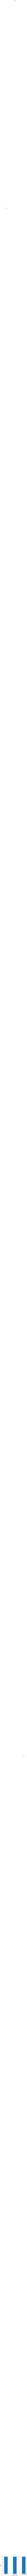

In [77]:
baseline_mape = mape(test['y'], test['baseline_pred'])
dt_mape = mape(test['y'], test['dt_pred'])
gbr_mape = mape(test['sales'], test['gbr_pred'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_mape, gbr_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 0.3)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

<ipython-input-78-ed96ed3fab34>:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


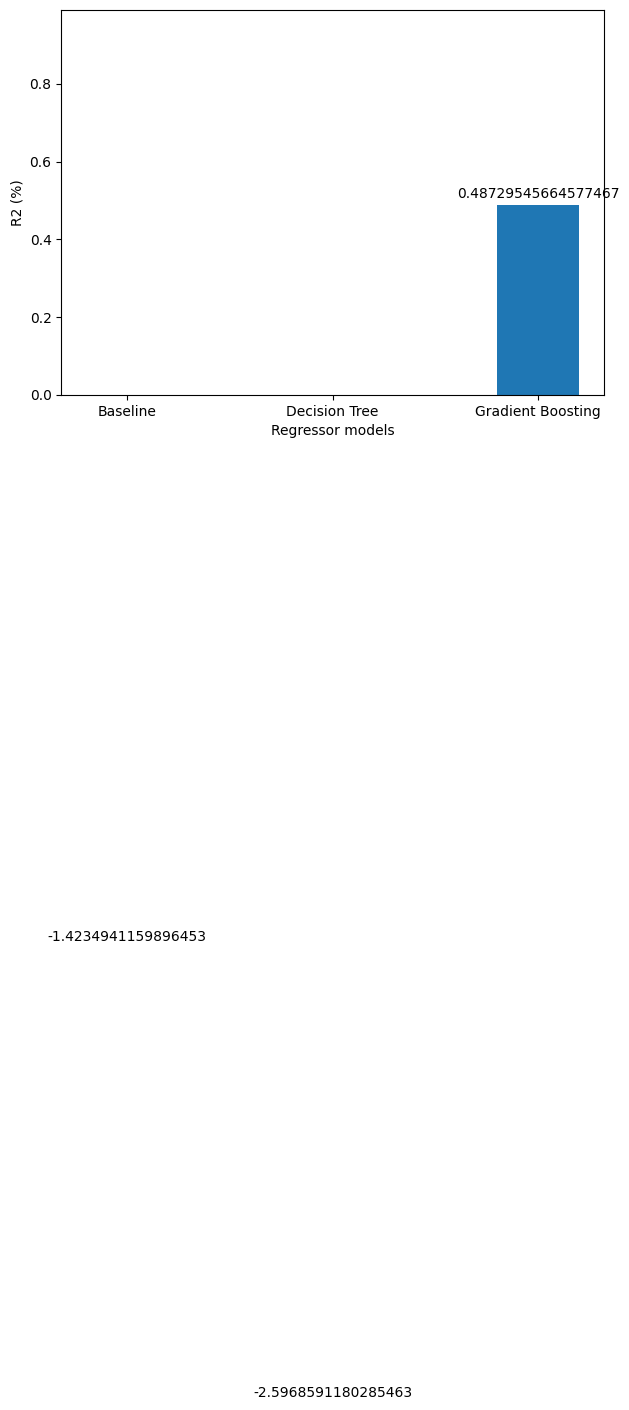

In [78]:
test = test.fillna(0)
from sklearn.metrics import r2_score
baseline_r2 = r2_score(test['y'], test['baseline_pred'])
dt_r2 = r2_score(test['y'], test['dt_pred'])
gbr_r2 = r2_score(test['sales'], test['gbr_pred'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_r2, dt_r2, gbr_r2]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('R2 (%)')
ax.set_ylim(0, 0.99)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

Revisamos las métricas

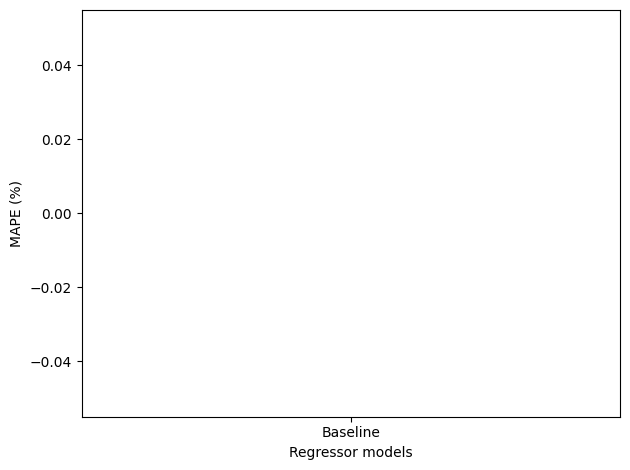

In [79]:
baseline_mape = mape(y_test, baseline_pred)
dt_5_mape = mape(y_test, dt_reg_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_5_mape, gbr_5_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
#ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

##Predicción utilizando una secuencia de valores pasados:

In [80]:
new_df = window_input(10, data_tris_train)

In [81]:
from sklearn.model_selection import train_test_split

X = new_df.drop('y',axis=1).values
y = new_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [82]:
baseline_pred = []

for row in X_test:
    baseline_pred.append(np.mean(row))

In [83]:
gbr_5 = GradientBoostingRegressor(random_state=42)

gbr_5.fit(X_train, y_train.ravel())

gbr_5_pred = gbr_5.predict(X_test)

Revisamos las métricas

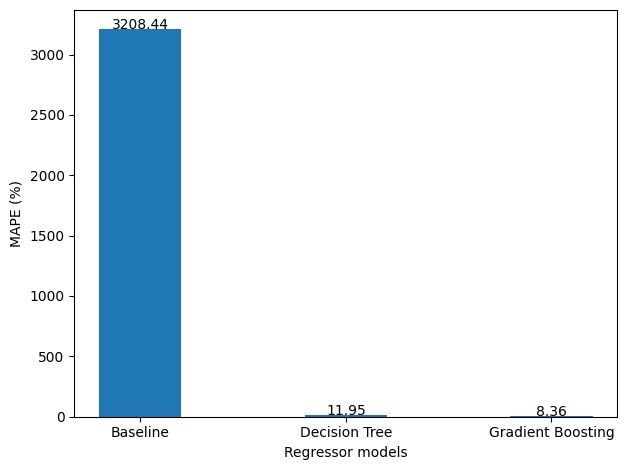

In [84]:
baseline_mape = mape(y_test, baseline_pred)
dt_5_mape = mape(y_test, dt_reg_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_5_mape, gbr_5_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
#ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()